## Object selectivity (Fig 4)

This code analyzes basic properties of object selectivity and generate plots in Fig 4

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

from scipy import stats
import statsmodels.api as sm

import pingouin as pg

import matplotlib as mpl
import matplotlib.pyplot as plt

from datetime import date
import time

import h5py

In [2]:
# no top and right spines in all plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [2]:
# Make sure you change "mother_path" properly to run this code
mother_path = Path('C:/multimodal-object-recognition-PER/')

fig_path = mother_path / 'result' / 'figures'
os.makedirs(fig_path,exist_ok=True)

### Parameter setting

In [4]:
gauss_sigma = 2

# colors for multimodal, vis-only, aud-only conditions
color = ['mediumorchid','cornflowerblue','lightcoral','gray']
color2 = ['cyan','magenta','gray']
linestyle = ['-',':']

today = str(date.today())

### Data preparation

In [5]:
# load results from ANOVA
data_path = mother_path /'result'/'ANOVA'/'2023-07-10'
f = h5py.File(data_path/'2023-07-10_ANOVA_result.hdf5','r')

# load results from multiple linear regression
data2_path = mother_path /'result'/'multiple linear regression'/'2023-07-10'
f2 = h5py.File(data2_path/'2023-07-10_multiple_regression_result.hdf5','r')

In [6]:
def h5_to_df(f):
    keys = list(f.keys())
    attributes = {}
    
    for key in keys:
        attributes[key] = dict(f[key].attrs.items())
    
    df = pd.DataFrame.from_dict(attributes, orient='index')
    df.index.name = 'key'
    df = df.reset_index()
    
    return df

In [7]:
# convert h5py to data frame

df = h5_to_df(f2)
df = df[(df['region']=='PER')&(df['response cell']==0)]
df.reset_index(inplace=True,drop=True)

object_bin_all = np.zeros((0,90))
object_peak = []

for key in df['key']:    
    df.loc[df['key']==key,'pref_obj'] = f[key].attrs['preferred object']
    df.loc[df['key']==key,'peak_selectivity'] = np.max(f[f'{key}/anova_eta'])  
    df.loc[df['key']==key,'peak_selectivity_time'] = f[key].attrs['peak selectivity time']
    df.loc[df['key']==key,'selectivity_duration'] = len(f[f'{key}/object_bin'])*10
    df.loc[df['key']==key,'selectivity_onset'] = np.min(f[f'{key}/object_bin'])*10
    df.loc[df['key']==key,'selectivity_index'] = np.abs(f[key].attrs['selectivity index'])
    
    selective_bin = np.zeros(90)
    selective_bin[f[f'{key}/object_bin']] = 1
    
    object_bin_all = np.append(object_bin_all, [selective_bin], axis=0)
    object_peak.append(df.loc[df['key']==key,'peak_selectivity_time'].item())

        
df['peak_selectivity_time_range'] = (df['peak_selectivity_time'] // 100) + 1
df['selectivity_onset_range'] = (df['peak_selectivity_time'] // 100) + 1

for i in range(len(df)):
    if df.loc[i,'peak_selectivity_time'] < 200:
        df.loc[i,'peak_selectivity_time_range2'] = 0
    elif 200 <= df.loc[i,'peak_selectivity_time'] < 400:
        df.loc[i,'peak_selectivity_time_range2'] = 1
    elif 400 <= df.loc[i,'peak_selectivity_time'] < 650:
        df.loc[i,'peak_selectivity_time_range2'] = 2
    elif 650 <= df.loc[i,'peak_selectivity_time'] < 900:
        df.loc[i,'peak_selectivity_time_range2'] = 3

### Population object selectivity (Fig 4C)

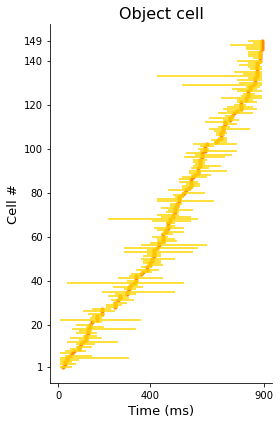

In [103]:
sorted_index = np.argsort(object_peak)
object_sorted = object_bin_all[sorted_index]

fig,ax = plt.subplots(figsize=(4,6))

for i in range(len(object_sorted)):
    s_start = np.min(np.where(object_sorted[i,:]))
    s_end = np.max(np.where(object_sorted[i,:]))
    ax.hlines(y=i, xmin = s_start, xmax = s_end, color='gold')
    ax.scatter(x=df.loc[sorted_index[i],'peak_selectivity_time']/10, y=i, color='darkorange', s=10)
    
ax.set_xticks([0,40,90])
ax.set_xticklabels([0,400,900])
ax.set_xlabel('Time (ms)',fontsize=13)
ax.set_yticks([0, 19, 39, 59, 79, 99, 119, 139, len(df)-1])
ax.set_yticklabels([1, 20, 40, 60, 80, 100, 120, 140, len(df)])
ax.set_ylabel('Cell #',fontsize=13)
ax.set_title('Object cell', fontsize=16)

plt.tight_layout()

#plt.savefig(fig_path / 'svg' / 'population_selectivity_object_cell.svg')

### Peak time vs. Selectivity duration (Fig 4D)

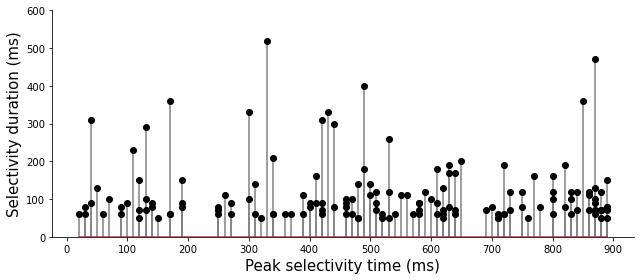

median of selectivity duration = 80.00


In [107]:
fig,ax = plt.subplots(figsize=(9,4))

ax.stem(df['peak_selectivity_time'],df['selectivity_duration'], linefmt = 'gray',
       markerfmt = 'ko')
ax.set_ylabel('Selectivity duration (ms)',fontsize=15)
ax.set_yticks(np.arange(0,700,100));
ax.set_ylim([0,600])
ax.set_xlabel('Peak selectivity time (ms)',fontsize=15)
ax.set_xticks(np.arange(0,1000,100));

xline = np.arange(0,900,1)
#ax.plot(xline,ln(xline,ln_result[0],ln_result[1]),color='tab:red',linestyle='-', linewidth=2)
#ax.plot(xline,poly(xline,poly_result[0],poly_result[1],poly_result[2]),
#       color='tab:red',linestyle='-.', linewidth=2)
#ax.plot(xline,sigmoid(xline,sigmoid_result[0],sigmoid_result[1],sigmoid_result[2],sigmoid_result[3]),
#        color='tab:red',linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()
#plt.savefig(fig_path / 'peaktime_duration_stem.png', dpi=300,facecolor='white')
#plt.savefig(fig_path / 'peaktime_duration_stem.svg')

median_duration = np.median(df['selectivity_duration'])
ax.axhline(y=median_duration, color='red', linestyle='--')
print(f'median of selectivity duration = {median_duration:.2f}')

### Peak time vs. Selectivity duration (Fig 4E)

                         Source            SS   DF           MS         F  \
0  peak_selectivity_time_range2  2.945856e+03    3   981.951849  0.138651   
1                        Within  1.026913e+06  145  7082.160033       NaN   

      p-unc      np2  
0  0.936753  0.00286  
1       NaN      NaN  


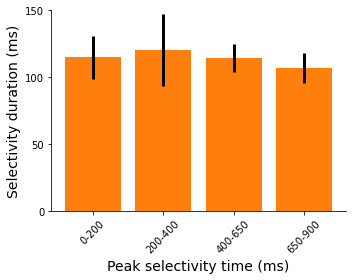

In [109]:
fig,ax = plt.subplots(figsize=(5,4))

x = range(4)
y = df.groupby('peak_selectivity_time_range2').mean()['selectivity_duration']
yerr = df.groupby('peak_selectivity_time_range2').sem()['selectivity_duration']

ax.bar(x=x, height=y, color='tab:orange')
ax.errorbar(x=x, y=y, yerr=yerr, fmt='none',color='black', linewidth=3)
#ax.set_yticks(np.arange(0,210,50))
ax.set_ylabel('Selectivity duration (ms)',fontsize=14)
ax.set_xlabel('Peak selectivity time (ms)',fontsize=14)
ax.set_xticks(range(4))
ax.set_xticklabels(['0-200','200-400','400-650','650-900'])
ax.tick_params(axis='x',labelrotation=45);
ax.set_yticks(np.arange(0,200,50))
ax.set_ylim([0, 150])

plt.tight_layout()
#plt.show()
#plt.savefig(fig_path / 'selectivity_duration_bar.png', dpi=300,facecolor='white')
plt.savefig(fig_path / 'svg' / 'selectivity_duration_bar.svg')

anova_result = pg.anova(data=df, dv='selectivity_duration', between='peak_selectivity_time_range2', detailed=True)
print(anova_result)

In [22]:
pg.anova(data=df, dv='selectivity_duration', between='peak_selectivity_time_range2', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,peak_selectivity_time_range2,3.531103e+04,3,11770.344146,1.171702,0.322003,0.019473
1,Within,1.778055e+06,177,10045.506855,NaN,NaN,NaN
